示例文件，短期预测（240 小时）。代码逻辑与 `improved/main.py` 基本相同，只是以 Jupyter Notebook 形式编写。


In [1]:
import random
from typing import Literal

import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset

from ml_fall_2024_final.constants import OUTPUT_WINDOW_LONG, OUTPUT_WINDOW_SHORT
from ml_fall_2024_final.dataset import read_test_data, read_train_data
from ml_fall_2024_final.improved.model import CNNLSTM
from ml_fall_2024_final.improved.preprocess import preprocess_data
from ml_fall_2024_final.improved.trainer import evaluate_model, train_model

In [ ]:
OUTPUT_WINDOW: Literal["short", "long"] = "long"
OUTPUT_WINDOW_LENGTH = OUTPUT_WINDOW_SHORT if OUTPUT_WINDOW == "short" else OUTPUT_WINDOW_LONG

In [3]:
train_data = read_train_data().dropna().drop(columns=["dteday"])
test_data = read_test_data().dropna().drop(columns=["dteday"])

# 指定离散列
discrete_cols = ["season", "yr", "mnth", "hr", "holiday", "weekday", "workingday", "weathersit"]

# 数据预处理
X_cont_train, X_cat_train, y_train, scaler = preprocess_data(
    data=train_data,
    target_col="cnt",
    discrete_cols=discrete_cols,
    past_steps=OUTPUT_WINDOW_LENGTH,
    future_steps=OUTPUT_WINDOW_LENGTH,
)
X_cont_test, X_cat_test, y_test, _ = preprocess_data(
    data=test_data,
    target_col="cnt",
    discrete_cols=discrete_cols,
    past_steps=OUTPUT_WINDOW_LENGTH,
    future_steps=OUTPUT_WINDOW_LENGTH,
)

# 转换为 Tensor
X_cont_train_tensor = torch.tensor(X_cont_train, dtype=torch.float32)
X_cat_train_tensor = torch.tensor(X_cat_train, dtype=torch.long)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

X_cont_test_tensor = torch.tensor(X_cont_test, dtype=torch.float32)
X_cat_test_tensor = torch.tensor(X_cat_test, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# 创建 DataLoader
batch_size = 16
train_dataset = TensorDataset(X_cont_train_tensor, X_cat_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_cont_test_tensor, X_cat_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [4]:
# 初始化模型
input_dim = X_cont_train.shape[2]  # 连续特征数量
hidden_dim = 64
kernel_size = 3
lstm_hidden_dim = 128
output_dim = y_train.shape[1]  # 预测步长

model = CNNLSTM(input_dim, hidden_dim, kernel_size, lstm_hidden_dim, output_dim)

In [5]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [6]:
train_model(model, train_loader, criterion, optimizer, epochs=20)

Epoch 1/20, Train Loss: 0.0162
Epoch 2/20, Train Loss: 0.0120
Epoch 3/20, Train Loss: 0.0106
Epoch 4/20, Train Loss: 0.0095
Epoch 5/20, Train Loss: 0.0082
Epoch 6/20, Train Loss: 0.0103
Epoch 7/20, Train Loss: 0.0100
Epoch 8/20, Train Loss: 0.0090
Epoch 9/20, Train Loss: 0.0074
Epoch 10/20, Train Loss: 0.0068
Epoch 11/20, Train Loss: 0.0064
Epoch 12/20, Train Loss: 0.0066
Epoch 13/20, Train Loss: 0.0058
Epoch 14/20, Train Loss: 0.0056
Epoch 15/20, Train Loss: 0.0056
Epoch 16/20, Train Loss: 0.0053
Epoch 17/20, Train Loss: 0.0051
Epoch 18/20, Train Loss: 0.0066
Epoch 19/20, Train Loss: 0.0062
Epoch 20/20, Train Loss: 0.0071


torch.Size([240, 6])
Test Loss: 0.0317
MAE: 126.1188 ± 25.4637
MSE: 31165.9531 ± 10887.0358


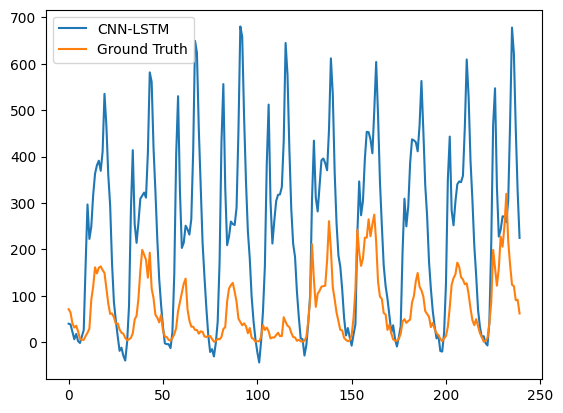

In [8]:
# 测试模型
predictions, targets, mae_list, mse_list = evaluate_model(model, test_loader, criterion, scaler)
selected_maes = []
selected_mses = []
for _ in range(5):
    idx = random.randint(0, len(predictions) - 1)  # noqa: S311
    selected_maes.append(mae_list[idx])
    selected_mses.append(mse_list[idx])
mae_std = np.std(selected_maes)
mse_std = np.std(selected_mses)
print(f"MAE: {np.mean(selected_maes):.4f} ± {mae_std:.4f}")
print(f"MSE: {np.mean(selected_mses):.4f} ± {mse_std:.4f}")

# 绘制预测结果
plt.plot(predictions[-1], label="CNN-LSTM")
plt.plot(targets[-1], label="Ground Truth")
plt.legend()
plt.show()